x_center                        49597
y_center                         6227
approx_size                         3
box_x1                          49597
box_x2                          49598
box_y1                           6226
box_y2                           6229
min_value                   81.243927
max_value                   85.037254
circularity                       inf
mask_file      49597_6227_wUcPaFI.npy
Name: 4, dtype: object


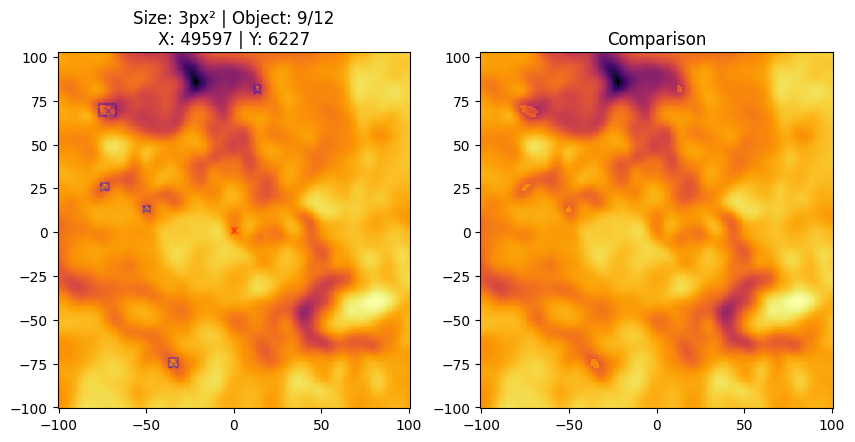

In [1]:
%matplotlib inline

import random

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib.colors import ListedColormap
from scipy import ndimage

plt.style.use({"image.origin": "lower", "image.interpolation": "nearest"})

FITS_PATH = '../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits'
# FITS_PATH = '../cnn/fits_for_annotation/box(50316.355, 6033.3671, 234.3168, 178.3296, 0.0).fits'
# Open img using memmap to not load the whole image into memory
imageHDU = fits.open(FITS_PATH, memmap=True, mode='denywrite')

# read catalog.csv
catalog = pd.read_csv('../data/catalog_test.csv', index_col=False, dtype={"x_center": np.int32, "y_center": np.int32, "approx_size": np.int32, "box_x1": np.int32, "box_x2": np.int32, "box_y1": np.int32, "box_y2": np.int32, "min_value": np.float32, "max_value": np.float32, "circularity": np.float32, "mask_file": str})

# catalog bigger then 1000px²
# catalog = catalog[catalog["approx_size"] >= 10000]
# catalog = catalog.reset_index(drop=True)

# print(catalog.head())

# plot random cloud
index = random.randint(0, len(catalog)-1)
# index = 1825
padding = 100
row = catalog.iloc[index]

nearby = catalog[(catalog["x_center"] > row["x_center"]-padding) & (catalog["x_center"] < row["x_center"]+padding) & (catalog["y_center"] > row["y_center"]-padding) & (catalog["y_center"] < row["y_center"]+padding)]
nearby = nearby[nearby["x_center"] != row["x_center"]] # remove self

print(row)

extent = (-padding-0.5, row["box_x2"]+padding-row["box_x1"]-0.5, -padding-0.5, row["box_y2"]+padding-row["box_y1"]-0.5)

rand_mask = np.load("../data/masks/"+row["mask_file"])

data = np.array(imageHDU[0].data[row["box_y1"]-padding:row["box_y2"]+padding, row["box_x1"]-padding:row["box_x2"]+padding], dtype=np.float32) # type: ignore

# blur data a little to make it understandable for humans
data = ndimage.gaussian_filter(data, sigma=3)

cmap1 = ListedColormap(['none', 'white']) # type: ignore

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

for index, nrow in nearby.iterrows():
    mask = np.load("../data/masks/"+nrow["mask_file"])
    if mask.shape != (nrow["box_y2"]-nrow["box_y1"], nrow["box_x2"]-nrow["box_x1"]):
        print("something is weird with the box", index)
        mask.resize((nrow["box_y2"]-nrow["box_y1"], nrow["box_x2"]-nrow["box_x1"]))

    data[(nrow["box_y1"]-row["box_y1"]+padding):(nrow["box_y2"]-row["box_y1"]+padding), (nrow["box_x1"]-row["box_x1"]+padding):(nrow["box_x2"]-row["box_x1"]+padding)] = data[(nrow["box_y1"]-row["box_y1"]+padding):(nrow["box_y2"]-row["box_y1"]+padding), (nrow["box_x1"]-row["box_x1"]+padding):(nrow["box_x2"]-row["box_x1"]+padding)] + mask*10


ax.imshow(data, cmap='inferno', extent=extent, norm=ImageNormalize(stretch=SqrtStretch())) #type: ignore
ax.imshow(rand_mask, cmap=cmap1, alpha=0.2)
ax.plot(row["x_center"]-row["box_x1"], row["y_center"]-row["box_y1"], 'rx', alpha=0.3)
ax.set_title("Size: " + str(int(row["approx_size"])) + "px² | Object: " + str(index+1) + "/" + str(len(catalog))+"\n"+"X: " + str(row["x_center"]) + " | Y: " + str(row["y_center"]))
ax.plot([-0.5, row["box_x2"]-row["box_x1"]-0.5, row["box_x2"]-row["box_x1"]-0.5, -0.5, -0.5], [-0.5, -0.5, row["box_y2"]-row["box_y1"]-0.5, row["box_y2"]-row["box_y1"]-0.5, -0.5], 'r-', alpha=0.3)

# print(extent)
# plot nearby clouds
for index, nrow in nearby.iterrows():
    ax.plot(nrow["x_center"]-row["box_x1"], nrow["y_center"]-row["box_y1"], 'bx', alpha=0.3)
    ax.plot([nrow["box_x1"], nrow["box_x2"], nrow["box_x2"], nrow["box_x1"], nrow["box_x1"]]-row["box_x1"], [nrow["box_y1"], nrow["box_y1"], nrow["box_y2"], nrow["box_y2"], nrow["box_y1"]]-row["box_y1"], 'b-', alpha=0.3)

    # nextent = (nrow["box_x1"]-row["box_x1"], nrow["box_x2"]-row["box_x1"], nrow["box_y1"]-row["box_y1"], nrow["box_y2"]-row["box_y1"])
    # print(nextent)
    # ax.imshow(rand_mask, cmap=cmap1, alpha=0.2, extent=nextent)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(data, cmap='inferno', extent=extent, norm=ImageNormalize(stretch=SqrtStretch()))
ax.set_title("Comparison");

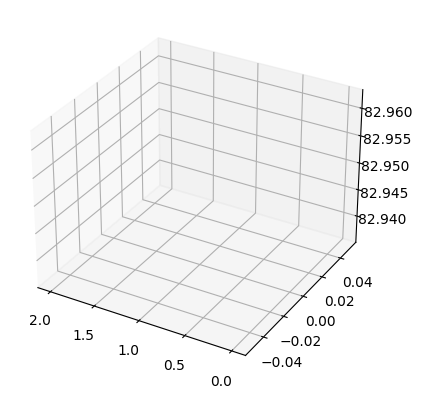

In [2]:
# interactive 3d plot of cloud
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

# mask times data
data_box = np.array(imageHDU[0].data[row["box_y1"]:row["box_y2"], row["box_x1"]:row["box_x2"]], dtype=np.float32) # type: ignore
data_box = ndimage.gaussian_filter(data_box, sigma=3)
# depth = rand_mask*data_box

# Set up grid and test data
nx, ny = data_box.shape
x = range(nx)
y = range(ny)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X.T, Y.T, data_box, cmap="inferno", antialiased=False)
plt.gca().invert_xaxis()

plt.show()

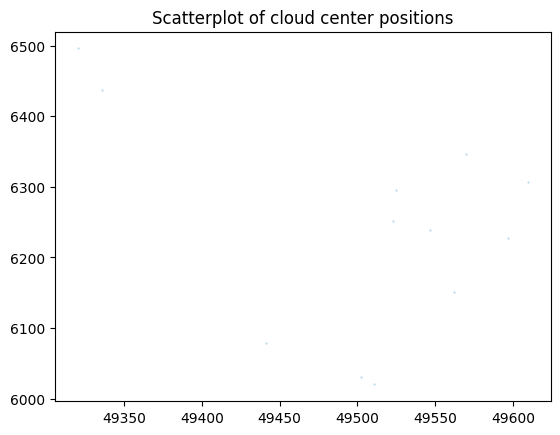

In [3]:
%matplotlib inline
# scatterplot of cloud center positions
plt.scatter(catalog["x_center"], catalog["y_center"], s=0.1, alpha=0.5)
plt.title("Scatterplot of cloud center positions");